In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats

# the Bayesian stuff
import bambi as bmb
import pymc as pm

# the frequentist stuff 
import statsmodels.api as sm

# plotting
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# RNG
rng = np.random.default_rng(seed=20240704)

## Example 2: Model misspecification - The importance of model checking

We now consider another artificial problem, but this time, where our model is actually wrong.

Suppose we have the following random sample of data:

In [2]:
N = 1000
Nsub = 100
x1 = np.random.normal(loc=[0.5,0.2], scale=[0.8,0.9], size=(N,2))
x2 = np.random.normal(loc=[1.5,2.5],scale=[0.6,0.6],size=(N,2))
x3 = np.random.normal(loc=[2.0,1.5],scale=[0.7,0.6],size=(N,2))
X = np.concatenate([x1,x2,x3], axis=0)

In [3]:
def subsample(lo=0,hi=1,n=1):
    return np.random.choice(range(lo,hi), size=n, replace=False)

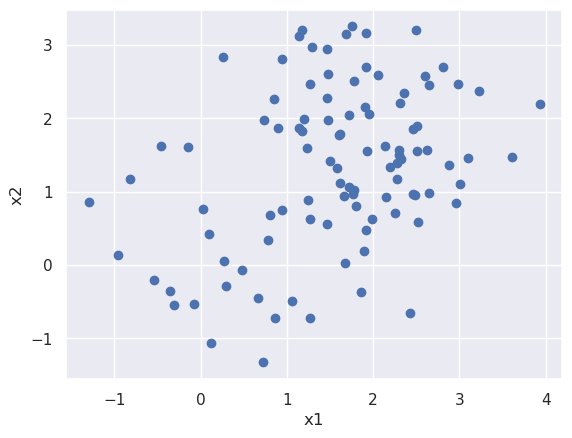

In [4]:
inds = subsample(hi=N*3,n=Nsub)
plt.scatter(X[inds,0],X[inds,1])
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

It's clear that there is a lot of variance, but we might be inclined to think there is a linear relationship between the two variables.

Unbenknownst to our hypothetical selves, the "true" data distribution is a 2-dimensional mixture of Gaussians:

$$
X \sim \text{UniformMixture}[\mathcal{N}(\vec{\mu}_1,\vec{\sigma}_1),\mathcal{N}(\vec{\mu}_2,\vec{\sigma}_2),\mathcal{N}(\vec{\mu}_3,\vec{\sigma}_3)]
$$

where $X \in \mathbb{R}^2$

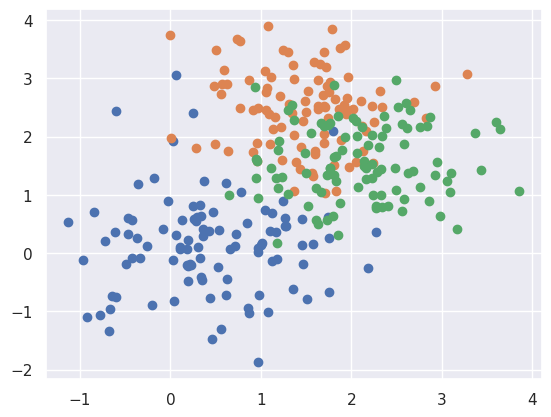

In [5]:
inds = subsample(hi=N,n=Nsub)
plt.scatter(x1[inds,0],x1[inds,1])
plt.scatter(x2[inds,0],x2[inds,1])
plt.scatter(x3[inds,0],x3[inds,1]);

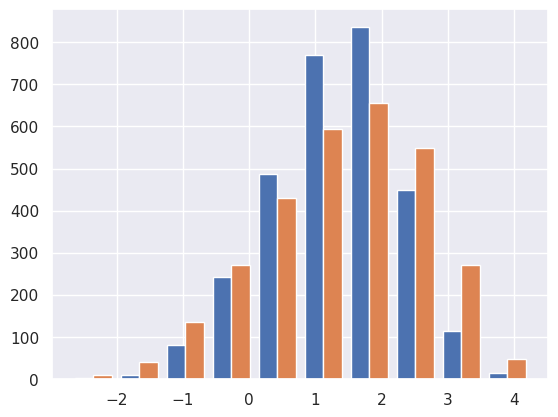

In [6]:
plt.hist(X);

Let's suppose we go ahead and naively fit a linear regression.

In [7]:
# take subsample for fitting
inds = subsample(hi=N*3,n=Nsub)
# fit OLS
y, x = X[inds,1],X[inds,0]
x_ = sm.add_constant(x)
res = sm.OLS(y,x_).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     15.31
Date:                Thu, 04 Jul 2024   Prob (F-statistic):           0.000168
Time:                        10:47:50   Log-Likelihood:                -144.11
No. Observations:                 100   AIC:                             292.2
Df Residuals:                      98   BIC:                             297.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0453      0.170      6.166      0.000       0.709       1.382
x1             0.4212      0.108      3.913      0.000       0.208       0.635
==============================================================================
Omnibus:                        0.811   Durbin-Watson:                   2.255
Prob(Omnibus):                  0.667   Jarque-Bera (JB):                0.932
Skew:                          -0.172   Prob(JB):                        0.627
Kurtosis:                       2.675   Cond. No.                         3.33
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Notice that $p << 0.05$ and we very clearly reject the null hypothesis.

There are *some* red flags (low $R^2$ and high omnibus) but these aren't necessarily out of the ordinary.

Of course we can be similarly naive with a Bayesian model.

Note that we here use `bambi` to very easily set up and fit a linear model.

In [8]:
import bambi as bmb

data_example2 = pd.DataFrame(X, columns=["x0","x1"])
linear_model = bmb.Model("x1 ~ x0", data_example2.iloc[inds])
linear_model

       Formula: x1 ~ x0
        Family: gaussian
          Link: mu = identity
  Observations: 100
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.5713, sigma: 4.5114)
            x0 ~ Normal(mu: 0.0, sigma: 2.8647)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 1.0994)

It is good practice to first do a prior predictve check and see if anything is obviously amiss.

In [9]:
linear_model.build()
prior_samples = linear_model.prior_predictive(draws=100)

Sampling: [Intercept, x0, x1, x1_sigma]


<Axes: xlabel='x1'>

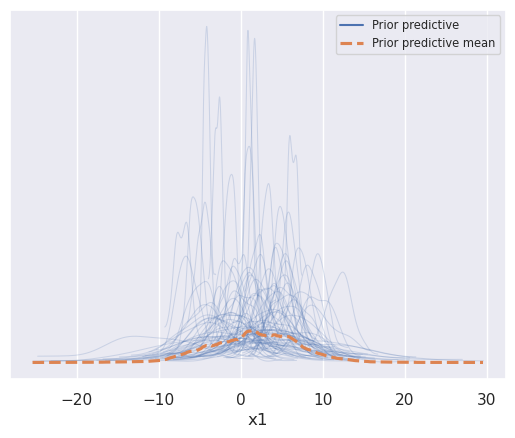

In [10]:
az.plot_ppc(prior_samples, group="prior")

The prior is clearly too diffuse and could be made tighter but otherwise the predictions look reasonable.

Let's go ahead and fit the model to see what we get.

In [11]:
inference_data = linear_model.fit(draws=1000, random_seed=1234)
# generate posterior predictive samples
linear_model.predict(inference_data, kind="pps");
# summarize posterior
az.summary(inference_data)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x1_sigma, Intercept, x0]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.046,0.167,0.741,1.365,0.002,0.002,6042.0,3067.0,1.0
x0,0.422,0.105,0.222,0.621,0.001,0.001,5857.0,3286.0,1.0
x1_sigma,1.040,0.073,0.904,1.179,0.001,0.001,5311.0,2527.0,1.0
x1_mean[0],1.442,0.112,1.231,1.645,0.001,0.001,5785.0,3076.0,1.0
x1_mean[1],1.493,0.109,1.291,1.694,0.001,0.001,5740.0,2991.0,1.0
...,...,...,...,...,...,...,...,...,...
x1_mean[95],1.000,0.176,0.670,1.332,0.002,0.002,6041.0,3051.0,1.0
x1_mean[96],1.315,0.124,1.095,1.556,0.002,0.001,5923.0,3047.0,1.0
x1_mean[97],1.359,0.119,1.141,1.584,0.002,0.001,5881.0,2998.0,1.0
x1_mean[98],2.462,0.250,1.986,2.924,0.003,0.002,5594.0,3042.0,1.0


We can see from the posterior predictive samples of the linear model that something is off. The expected distribution of predictions looks very different from the actual data!

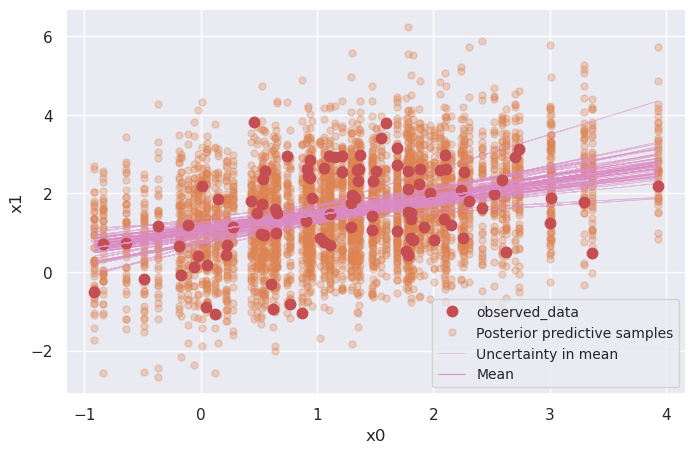

In [12]:
az.plot_lm("x1", inference_data, y_model="x1_mean", x=data_example2.x0.iloc[inds], figsize=(8,5));
plt.legend(loc='best', prop={'size': 10})
plt.show()

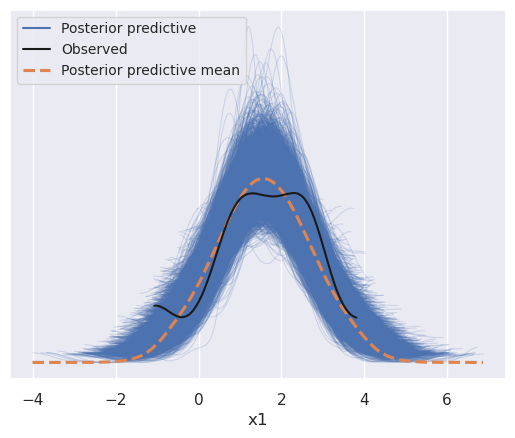

In [13]:
az.plot_ppc(inference_data, group="posterior", observed=True);
plt.legend(loc='upper left', prop={'size': 10})
plt.show()

#### Exercise

Try building a new model that models the data as a Gaussian mixture. Compare the posterior predictive check plots between the new model and the previous one.

You can refer to [this example](https://www.pymc.io/projects/examples/en/latest/mixture_models/gaussian_mixture_model.html) in the pymc docs to get started.

Note that you will need to write the pymc model directly rather than using bambi.